# *Process list of ParOSol outputs*
Voxel-uFE models solved in ParOSol

Created on:  14.11.2025 <br />
Last update: 14.11.2025 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2025
- Code license: MIT
- Narrative license: CC-BY-NC-SA

---
## Aims
![](./../../fem_pipeline.png)
This notebook does:
1. Load list of ParOSol `.h5` output files
2. Calculate apparent elastic modulus from reaction forces


---
## Configuration and imports

In [1]:
import sys
# sys.path.append('./../../')

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import h5py

from ciclope.utils.postprocess import reaction_forces

## Load list of files

In [4]:
data_path = '~/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/'
file_list = 'parosol_models_ds10_and_blur.lst'

In [6]:
# Read list of filenames from .lst file
lst_file_path = os.path.join(os.path.expanduser(data_path), file_list)

with open(lst_file_path, 'r') as f:
    file_paths = [line.strip() for line in f.readlines()]

# Replace absolute paths with data_path
file_paths = [os.path.join(os.path.expanduser(data_path), os.path.basename(fpath)) for fpath in file_paths]

print(f"Loaded {len(file_paths)} files from {file_list}")
for i, fpath in enumerate(file_paths):
    print(f"  {i+1}: {fpath}")

Loaded 15 files from parosol_models_ds10_and_blur.lst
  1: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/hr_idx0.h5
  2: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/hr_idx1.h5
  3: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/hr_idx2.h5
  4: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/hr_idx3.h5
  5: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/hr_idx4.h5
  6: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/sr_idx0.h5
  7: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/sr_idx1.h5
  8: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/sr_idx2.h5
  9: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/sr_idx3.h5
  10: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/sr_idx4.h5
  11: /home/giiori/termin

## Post-processing of FE results
### Read ParOSol output and Reaction forces

In [8]:
plane_lock_num = 10
slice_level = plane_lock_num + 1

In [20]:
# Read results for all files and store in DataFrame
import re
results_list = []

for fpath in file_paths:
    try:
        res = reaction_forces(fpath, slice_level)
        base = os.path.basename(fpath)
        # scale is prefix before first underscore (e.g., 'hr', 'sr', 'lr')
        scale = base.split('_')[0]
        # extract numeric index after 'idx'
        m = re.search(r'idx(\d+)', base)
        idx = int(m.group(1)) if m else None

        res['file'] = base
        res['idx'] = idx
        res['scale'] = scale
        results_list.append(res)
    except Exception as e:
        print(f"Error processing {fpath}: {e}")

# Create DataFrame from results
df_results = pd.DataFrame(results_list)

# Normalize types: idx as integer (nullable Int64)
if 'idx' in df_results.columns:
    df_results['idx'] = pd.to_numeric(df_results['idx'], errors='coerce').astype('Int64')

print(f"Created DataFrame with {len(df_results)} rows")
print(df_results.head())

Created DataFrame with 15 rows
    Z_min   Z_max                                        total_force  \
0  7.4538  7.7568  [0.08762033514891195, 0.15902115963607752, -0....   
1  7.4538  7.7568  [3.8158747735339924, -0.9018496032792342, -18....   
2  7.4538  7.7568  [-0.05047946213898251, 0.172884099925019, -0.6...   
3  7.4538  7.7568  [0.15099442834545662, 0.1493629945844796, -0.4...   
4  7.4538  7.7568  [1.2588094831198338, -0.58095697866525, -16.02...   

       F_tot  num_nodes  num_elements      vs  nodes_z0_count  nodes_z1_count  \
0   0.925369     887007        508111  0.0303           14361           14766   
1  19.351083    1120476        679728  0.0303           23460           17034   
2   0.671293     982703        558927  0.0303           15321           13576   
3   0.484465    1109307        625822  0.0303           13292           18157   
4  16.089503    1415430        871646  0.0303           24514           24970   

         file  idx scale  
0  hr_idx0.h5    0    

In [37]:
df_results[df_results['scale'] == 'hr']['F_tot']

0     0.925369
1    19.351083
2     0.671293
3     0.484465
4    16.089503
Name: F_tot, dtype: float64

In [38]:
df_results[df_results['scale'] == 'sr']['F_tot']

5      1.607571
6     46.665963
7      6.855891
8     39.378669
9    144.410516
Name: F_tot, dtype: float64

/tmp/ipykernel_833099/3885830972.py:3: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('SR', 'LR')


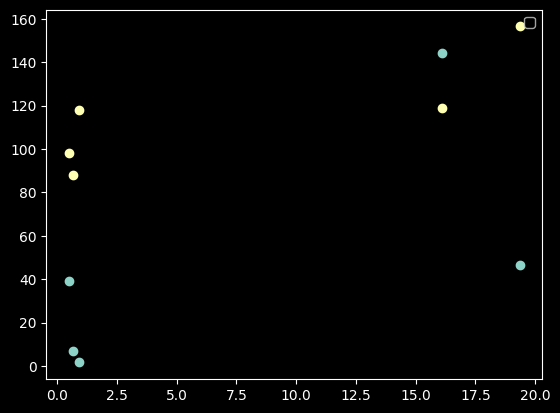

In [ ]:
plt.scatter(df_results[df_results['scale'] == 'hr']['F_tot'], df_results[df_results['scale'] == 'sr']['F_tot'])
plt.scatter(df_results[df_results['scale'] == 'hr']['F_tot'], df_results[df_results['scale'] == 'lr']['F_tot'])
plt.legend('SR', 'LR')

### Apparent elastic modulus
`E_app = (F_tot / A) / epsilon`

In [39]:
voxel_size_mm=0.0303
cube_size = 256
topDisplacement=-0.004

A = (cube_size*voxel_size_mm)**2 # [mm2]
epsilon = np.abs(topDisplacement)/(cube_size*voxel_size_mm)

In [44]:
print((df_results[df_results['scale'] == 'sr']['F_tot']/A)/epsilon)

5      51.811662
6    1504.033968
7     220.963909
8    1269.166051
9    4654.319960
Name: F_tot, dtype: float64
